In [1]:
# --- Core Python Libraries ---
import os
import time
import glob
import collections

# --- Data Handling and Processing ---
import numpy as np
import pandas as pd
from PIL import Image
import cv2  # We'll use OpenCV for drawing boxes later

# --- Data Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches # For drawing bounding boxes on plots

# --- PyTorch Core ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Torchvision (PyTorch's Vision Library) ---
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- Utilities ---
from tqdm import tqdm # For those satisfying progress bars!

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

# Check for GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu128
Torchvision Version: 0.23.0+cu128
Using device: cuda


In [2]:
# --- Define File Paths ---
ROOT_DIR = '.' 
DATASET_DIR = os.path.join(ROOT_DIR, 'dataset')

# Paths for image folders
TRAIN_IMG_DIR = os.path.join(DATASET_DIR, 'training_images')
TEST_IMG_DIR = os.path.join(DATASET_DIR, 'test_images')

# Paths for CSV files
TRAIN_IMAGES_META_CSV = os.path.join(DATASET_DIR, 'training_images.csv')
TRAIN_ELEPHANTS_CSV = os.path.join(DATASET_DIR, 'training_elephants.csv')
TEST_IMAGES_META_CSV = os.path.join(DATASET_DIR, 'test_images.csv')
TEST_ELEPHANTS_CSV = os.path.join(DATASET_DIR, 'test_elephants.csv')

# --- Training Hyperparameters ---
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# --- Model Configuration ---
RESIZE_TO = (512, 512)
NUM_CLASSES = 2 # 1 class (elephant) + 1 background

# --- Output Directory ---
OUT_DIR = os.path.join(ROOT_DIR, 'outputs')
os.makedirs(OUT_DIR, exist_ok=True)

print("Configuration set.")

Configuration set.


In [3]:
# FINAL CORRECTED VERSION of Cell 3

class ElephantDataset(Dataset):
    def __init__(self, img_dir, images_meta_csv, elephants_csv, resize_to, transforms=None):
        self.img_dir = img_dir
        self.images_df_all = pd.read_csv(images_meta_csv)
        self.elephants_df = pd.read_csv(elephants_csv)
        self.resize_to = resize_to
        self.transforms = transforms
        
        # --- FIX: Filter for images that have annotations ---
        # Get a list of all image names that have at least one elephant
        valid_image_names = self.elephants_df['image_name'].unique()
        
        # Filter the main images dataframe to only include images from the list above
        self.images_df = self.images_df_all[self.images_df_all['image_name'].isin(valid_image_names)].reset_index(drop=True)
        # --- END OF FIX ---
        
    def __len__(self):
        return len(self.images_df)
        
    def __getitem__(self, idx):
        # Get image info from the (now filtered) images_df dataframe
        image_info = self.images_df.iloc[idx]
        image_name_hash = image_info['image_name']
        
        image_filename = f"{image_name_hash}.jpg"
        image_path = os.path.join(self.img_dir, image_filename)
        
        image = Image.open(image_path).convert('RGB')
        
        orig_w = image_info['image_width']
        orig_h = image_info['image_height']
        
        image = image.resize(self.resize_to)
        
        records = self.elephants_df[self.elephants_df['image_name'] == image_name_hash]
        
        boxes = []
        labels = []
        
        box_width = 80
        box_height = 80
        
        for _, row in records.iterrows():
            x_coord = row['x']
            y_coord = row['y']
            
            xmin = x_coord - (box_width / 2)
            ymin = y_coord - (box_height / 2)
            xmax = x_coord + (box_width / 2)
            ymax = y_coord + (box_height / 2)
            
            x_scale = self.resize_to[0] / orig_w
            y_scale = self.resize_to[1] / orig_h
            
            scaled_xmin = xmin * x_scale
            scaled_ymin = ymin * y_scale
            scaled_xmax = xmax * x_scale
            scaled_ymax = ymax * y_scale
            
            boxes.append([scaled_xmin, scaled_ymin, scaled_xmax, scaled_ymax])
            labels.append(1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, target

print("Final corrected ElephantDataset class defined successfully.")

Final corrected ElephantDataset class defined successfully.


Number of training images: 1629
Number of validation images: 437


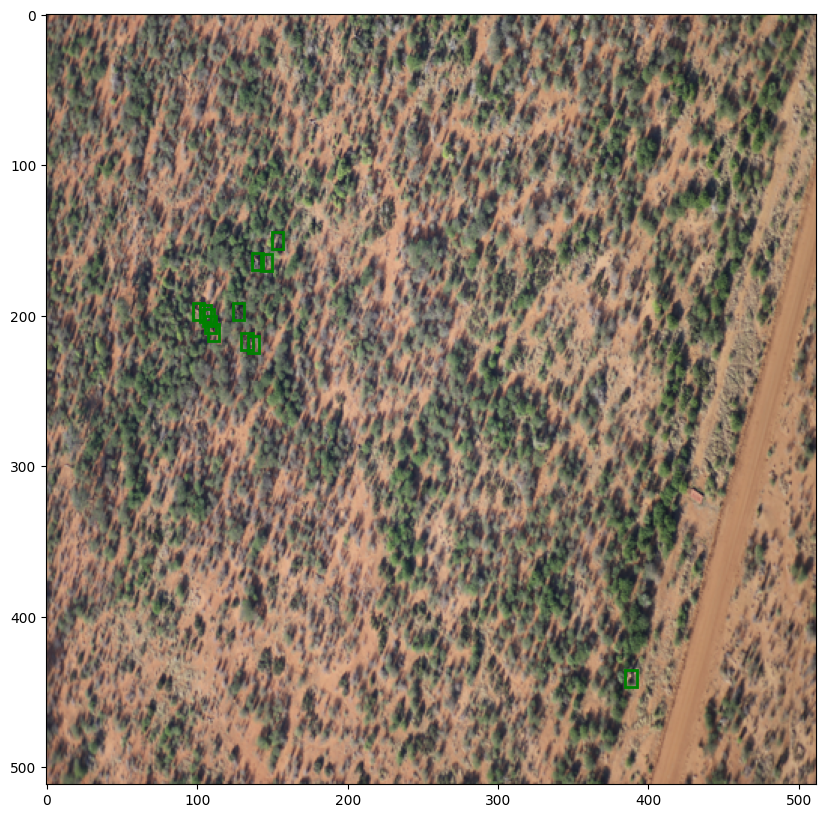

In [4]:
# --- Define Image Transformations ---
def get_transform(train):
    transforms_list = []
    transforms_list.append(transforms.ToTensor())
    return transforms.Compose(transforms_list)
    
# --- Create the Datasets ---
train_transform = get_transform(train=True)
valid_transform = get_transform(train=False)

train_dataset = ElephantDataset(
    img_dir=TRAIN_IMG_DIR,
    images_meta_csv=TRAIN_IMAGES_META_CSV, # <-- New argument
    elephants_csv=TRAIN_ELEPHANTS_CSV,     # <-- New argument
    resize_to=RESIZE_TO,
    transforms=train_transform
)
valid_dataset = ElephantDataset(
    img_dir=TEST_IMG_DIR,
    images_meta_csv=TEST_IMAGES_META_CSV, # <-- New argument
    elephants_csv=TEST_ELEPHANTS_CSV,     # <-- New argument
    resize_to=RESIZE_TO,
    transforms=valid_transform
)

# --- Create the DataLoaders ---
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)}")

# --- Sanity Check Visualization ---
if len(train_dataset) > 0:
    images, targets = next(iter(train_loader))
    image = images[0].permute(1, 2, 0).numpy()
    target = targets[0]
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [5]:
def create_model(num_classes):
    # Load a pre-trained Faster R-CNN model
    # We use the recommended modern weights API for best results
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # --- Perform the "Brain Surgery" ---
    # Replace the pre-trained head with a new, untrained one.
    # The new head will have `in_features` coming in and `num_classes` going out.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# --- Instantiate the Model and Optimizer ---

# Create the model for our number of classes (2)
model = create_model(NUM_CLASSES)

# Move the model to the GPU
model = model.to(device)

# Define the optimizer
# We'll use SGD (Stochastic Gradient Descent) which is a standard choice for this model
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, 
    lr=LEARNING_RATE, 
    momentum=MOMENTUM, 
    weight_decay=WEIGHT_DECAY
)

print("Model created and moved to GPU successfully.")
# You can uncomment the line below to see the full model architecture
# print(model)

Model created and moved to GPU successfully.


In [6]:
# # --- Helper Functions for Training and Validation ---

# # --- Corrected train_one_epoch function ---

# # --- Option 1: train_one_epoch with forced refresh ---

# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.train() 
#     print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    
#     prog_bar = tqdm(data_loader, total=len(data_loader))
#     total_loss = 0.0
    
#     for i, (images, targets) in enumerate(prog_bar):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()
        
#         total_loss += loss_value
        
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
        
#         prog_bar.set_description(desc=f"Training Loss: {loss_value:.4f}")
#         prog_bar.refresh() # <--- THE FIX: Manually force the progress bar to update
        
#     return total_loss / len(data_loader)

# # --- Corrected validate function ---

# def validate(model, data_loader, device):
#     model.eval() # Keep the model in evaluation mode for the function context
    
#     print("\nValidating...")
    
#     total_loss = 0.0
    
#     with torch.no_grad(): # Turn off gradients for validation
#         for i, (images, targets) in enumerate(data_loader):
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             # --- THE FIX IS HERE ---
#             # Temporarily switch to train() mode to get the loss dictionary
#             model.train()
#             loss_dict = model(images, targets)
#             # Switch back to eval() mode immediately
#             model.eval()
#             # --- END OF FIX ---
            
#             losses = sum(loss for loss in loss_dict.values())
#             loss_value = losses.item()
#             total_loss += loss_value
            
#     return total_loss / len(data_loader)

# # --- The Main Training Loop ---

# # To store our training history
# train_loss_history = []
# valid_loss_history = []

# for epoch in range(EPOCHS):
#     # Train for one epoch and get the average loss
#     train_epoch_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    
#     # Validate the model and get the average loss
#     valid_epoch_loss = validate(model, valid_loader, device)
    
#     # Store the losses
#     train_loss_history.append(train_epoch_loss)
#     valid_loss_history.append(valid_epoch_loss)
    
#     print(f"Epoch {epoch+1} Summary: Training Loss: {train_epoch_loss:.4f}, Validation Loss: {valid_epoch_loss:.4f}")
    
#     # --- Save the Model Checkpoint ---
#     # We save the model's state after each epoch.
#     checkpoint_path = os.path.join(OUT_DIR, f"model_epoch_{epoch+1}.pth")
#     torch.save({
#         'epoch': epoch + 1,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'train_loss': train_epoch_loss,
#         'valid_loss': valid_epoch_loss
#     }, checkpoint_path)
    
#     print(f"Checkpoint saved to {checkpoint_path}")

# print("\n--- TRAINING COMPLETE ---")

In [7]:
# # --- CELL 7: Visualize Training History ---

# # Plot the training and validation loss
# plt.figure(figsize=(10, 7))
# plt.plot(train_loss_history, color='blue', linestyle='-', label='Training Loss')
# plt.plot(valid_loss_history, color='red', linestyle='-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Find the epoch with the lowest validation loss
# best_epoch_index = np.argmin(valid_loss_history)
# best_valid_loss = valid_loss_history[best_epoch_index]
# print(f"The best model was at Epoch {best_epoch_index + 1} with a validation loss of {best_valid_loss:.4f}")

Loading model checkpoint from: ./outputs/model_epoch_5.pth


/tmp/ipykernel_5895/2690170480.py:45: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_to_draw = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)


./dataset/test_images/91374f14c2bf49792b591c6aa0f8ad66b220bf16.jpg


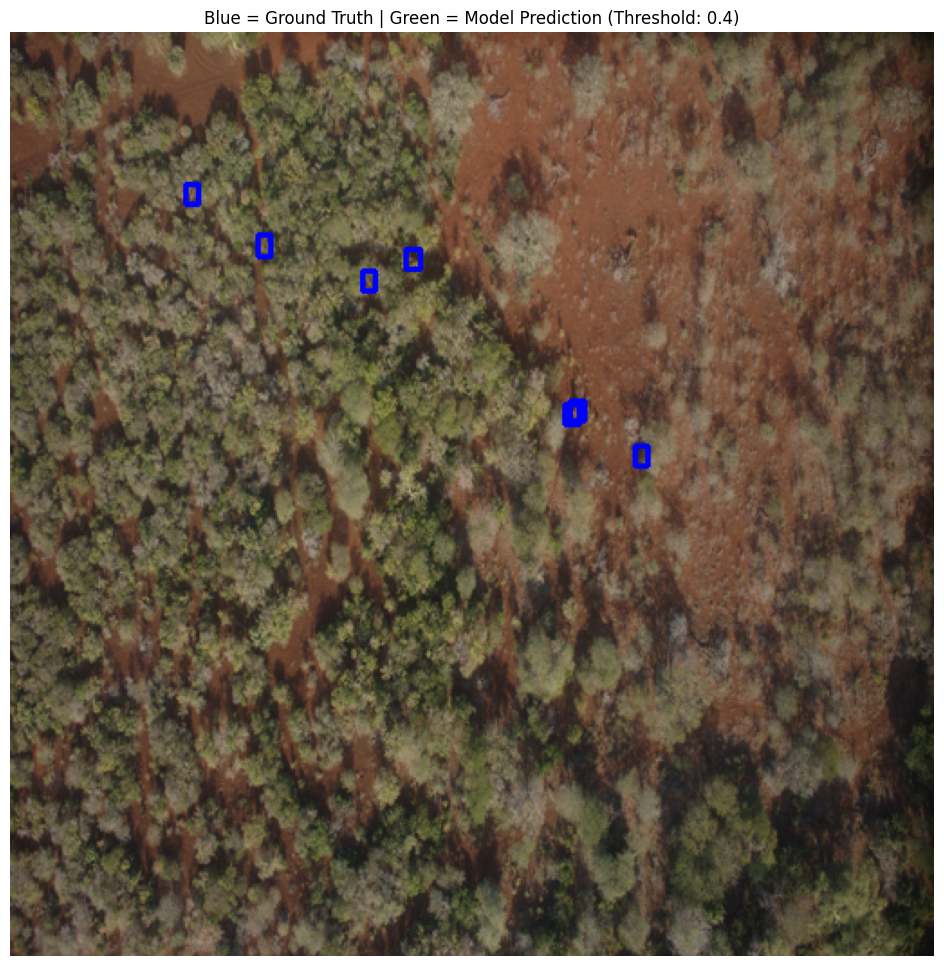

In [9]:
# --- CELL 8: Inference and Visualization ---

import random

# --- Configuration ---
# Let's load our best model from epoch 5
MODEL_CHECKPOINT = os.path.join(OUT_DIR, 'model_epoch_5.pth')
# Set a confidence threshold for predictions
CONFIDENCE_THRESHOLD = 0.4

# 1. --- Load the Best Model ---
print(f"Loading model checkpoint from: {MODEL_CHECKPOINT}")
# Load the checkpoint dictionary
checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
# Create the model architecture
model_inference = create_model(num_classes=NUM_CLASSES)
# Load the trained weights into the model
model_inference.load_state_dict(checkpoint['model_state_dict'])
# Move the model to the GPU and set it to evaluation mode
model_inference = model_inference.to(device)
model_inference.eval()

# 2. --- Prepare a Random Test Image ---
# Pick a random image from our validation dataset
img_index = random.randint(0, len(valid_dataset) - 1)
image_tensor, target = valid_dataset[img_index]

# The image_tensor is already transformed. We need the original PIL image for drawing.
# Let's get the image path and open it again.
image_path = os.path.join(TEST_IMG_DIR, f"{valid_dataset.images_df.iloc[img_index]['image_name']}.jpg")
original_image = Image.open(image_path).convert('RGB')
original_image = original_image.resize(RESIZE_TO) # Resize to match model input

# 3. --- Make a Prediction ---
# Add a batch dimension to the image tensor and move it to the device
input_tensor = image_tensor.unsqueeze(0).to(device)
with torch.no_grad():
    outputs = model_inference(input_tensor)

# The output is on the GPU, move it to the CPU for processing
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

# 4. --- Visualize the Results ---
# Convert the PIL image to a format OpenCV can use for drawing
image_to_draw = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)

# Draw GROUND TRUTH boxes (in BLUE)
for box in target['boxes']:
    xmin, ymin, xmax, ymax = map(int, box)
    cv2.rectangle(image_to_draw, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2) # Blue for ground truth

# Filter predictions by confidence and draw PREDICTED boxes (in GREEN)
if len(outputs[0]['boxes']) > 0:
    for i, box in enumerate(outputs[0]['boxes']):
        score = outputs[0]['scores'][i].item()
        if score > CONFIDENCE_THRESHOLD:
            xmin, ymin, xmax, ymax = map(int, box)
            # Draw the box
            cv2.rectangle(image_to_draw, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2) # Green for predictions
            # Put the confidence score text
            text = f"{score*100:.0f}%"
            cv2.putText(image_to_draw, text, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
print(image_path)
# Display the image
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_to_draw, cv2.COLOR_BGR2RGB))
plt.title(f"Blue = Ground Truth | Green = Model Prediction (Threshold: {CONFIDENCE_THRESHOLD})")
plt.axis('off')
plt.show()